In [5]:
%%bigquery raw_pd --verbose
SELECT date,
       airline,
       departure_airport,
       arrival_airport,
       departure_lat,
       departure_lon,
       arrival_lat,
       arrival_lon,
       departure_delay,
       arrival_delay
FROM `bigquery-samples.airline_ontime_data.flights`
Where departure_airport = 'SFO' AND date >= '2009-01-01' AND date <= '2009-12-31'

Executing query with job ID: 084428ea-1d4e-4132-9dd8-39e17435f446
Query executing: 0.39s
Query complete after 0.72s


Downloading: 100%|██████████| 134990/134990 [00:01<00:00, 118386.87rows/s]


In [27]:
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

**1. Load raw data into Pandas dataframe**

**2.Look for NULL values and treat them**

In [7]:
raw_pd.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 134990 entries, 0 to 134989
Data columns (total 10 columns):
 #   Column             Non-Null Count   Dtype  
---  ------             --------------   -----  
 0   date               134990 non-null  object 
 1   airline            134990 non-null  object 
 2   departure_airport  134990 non-null  object 
 3   arrival_airport    134990 non-null  object 
 4   departure_lat      134990 non-null  float64
 5   departure_lon      134990 non-null  float64
 6   arrival_lat        134990 non-null  float64
 7   arrival_lon        134990 non-null  float64
 8   departure_delay    134990 non-null  float64
 9   arrival_delay      134990 non-null  float64
dtypes: float64(6), object(4)
memory usage: 10.3+ MB


In [8]:
raw_pd.isnull().sum()

date                 0
airline              0
departure_airport    0
arrival_airport      0
departure_lat        0
departure_lon        0
arrival_lat          0
arrival_lon          0
departure_delay      0
arrival_delay        0
dtype: int64

In [9]:
raw_pd.shape

(134990, 10)

<AxesSubplot:xlabel='departure_delay', ylabel='arrival_delay'>

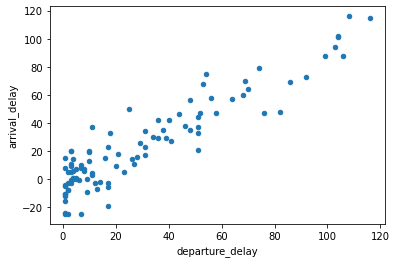

In [10]:
raw_pd = (raw_pd
                        .query('1 <= departure_delay <= 120')
                        .dropna()
                        .filter(['departure_delay', 'arrival_delay'])
                       )

(raw_pd
 .sample(n=100, random_state = 123)
 .plot.scatter('departure_delay', 'arrival_delay'))

**3. Other Data Preparation - Labeling**

**4. Split data into Training set and Testing set**

In [11]:
x_train = raw_pd.sample(frac=0.8).copy()

In [12]:
x_test = raw_pd.drop(x_train.index)

**5. Separate Label from Features**

In [13]:
y_train = x_train['arrival_delay']

In [15]:
x_train = x_train.drop(['arrival_delay'], axis=1)

In [16]:
x_train.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 38228 entries, 110890 to 49331
Data columns (total 1 columns):
 #   Column           Non-Null Count  Dtype  
---  ------           --------------  -----  
 0   departure_delay  38228 non-null  float64
dtypes: float64(1)
memory usage: 597.3 KB


In [17]:
x_train.shape

(38228, 1)

In [18]:
y_train.shape

(38228,)

In [19]:
y_test = x_test['arrival_delay']

In [21]:
x_test = x_test.drop(['arrival_delay'], axis=1)

In [22]:
x_test.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 9557 entries, 16 to 134975
Data columns (total 1 columns):
 #   Column           Non-Null Count  Dtype  
---  ------           --------------  -----  
 0   departure_delay  9557 non-null   float64
dtypes: float64(1)
memory usage: 149.3 KB


In [23]:
x_test.shape

(9557, 1)

In [24]:
y_test.shape

(9557,)

**6. Designing a neural network for model training**

In [25]:
def build_model():
  model = keras.Sequential([
    layers.Dense(1, activation='linear', input_shape = (1,))
   ])
  
  optimizer = tf.keras.optimizers.RMSprop()
  model.compile(loss='mse',
              optimizer=optimizer,
              metrics=['mae', 'mse'])
  return model

In [28]:
model = build_model()
model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense (Dense)                (None, 1)                 2         
Total params: 2
Trainable params: 2
Non-trainable params: 0
_________________________________________________________________


2021-11-24 16:23:22.065818: I tensorflow/core/platform/profile_utils/cpu_utils.cc:104] CPU Frequency: 2199995000 Hz
2021-11-24 16:23:22.066866: I tensorflow/compiler/xla/service/service.cc:168] XLA service 0x55ca35f24750 initialized for platform Host (this does not guarantee that XLA will be used). Devices:
2021-11-24 16:23:22.066900: I tensorflow/compiler/xla/service/service.cc:176]   StreamExecutor device (0): Host, Default Version
2021-11-24 16:23:22.069389: I tensorflow/core/common_runtime/process_util.cc:146] Creating new thread pool with default inter op setting: 2. Tune using inter_op_parallelism_threads for best performance.


**7. Launch the model training**

In [29]:
EPOCHS = 10

history = model.fit(
 x_train, y_train,
 epochs=EPOCHS, callbacks=[tf.keras.callbacks.TensorBoard("logs/simple-regression")])


2021-11-24 16:24:40.276477: I tensorflow/core/profiler/lib/profiler_session.cc:164] Profiler session started.


Epoch 1/10
   1/1195 [..............................] - ETA: 0s - loss: 9497.2227 - mae: 69.1799 - mse: 9497.2227WARNING:tensorflow:From /opt/conda/lib/python3.7/site-packages/tensorflow/python/ops/summary_ops_v2.py:1277: stop (from tensorflow.python.eager.profiler) is deprecated and will be removed after 2020-07-01.
Instructions for updating:
use `tf.profiler.experimental.stop` instead.
  46/1195 [>.............................] - ETA: 3s - loss: 6809.8765 - mae: 55.8910 - mse: 6809.8765

2021-11-24 16:24:41.183133: I tensorflow/core/profiler/lib/profiler_session.cc:164] Profiler session started.
2021-11-24 16:24:41.218357: I tensorflow/core/profiler/rpc/client/save_profile.cc:176] Creating directory: logs/simple-regression/train/plugins/profile/2021_11_24_16_24_41
2021-11-24 16:24:41.220059: I tensorflow/core/profiler/rpc/client/save_profile.cc:182] Dumped gzipped tool data for trace.json.gz to logs/simple-regression/train/plugins/profile/2021_11_24_16_24_41/tensorflow-2-3-20211124-225315.trace.json.gz
2021-11-24 16:24:41.236377: I tensorflow/core/profiler/rpc/client/save_profile.cc:176] Creating directory: logs/simple-regression/train/plugins/profile/2021_11_24_16_24_41
2021-11-24 16:24:41.236754: I tensorflow/core/profiler/rpc/client/save_profile.cc:182] Dumped gzipped tool data for memory_profile.json.gz to logs/simple-regression/train/plugins/profile/2021_11_24_16_24_41/tensorflow-2-3-20211124-225315.memory_profile.json.gz
2021-11-24 16:24:41.237326: I tensorflow/p

1195/1195 [==============================] - 2s 2ms/step - loss: 4053.4883 - mae: 42.2086 - mse: 4053.4883
Epoch 2/10
1195/1195 [==============================] - 2s 2ms/step - loss: 580.8887 - mae: 16.2271 - mse: 580.8887
Epoch 3/10
1195/1195 [==============================] - 2s 2ms/step - loss: 181.4493 - mae: 10.1239 - mse: 181.4493
Epoch 4/10
1195/1195 [==============================] - 2s 2ms/step - loss: 175.1755 - mae: 9.8683 - mse: 175.1755
Epoch 5/10
1195/1195 [==============================] - 2s 2ms/step - loss: 170.2709 - mae: 9.6644 - mse: 170.2709
Epoch 6/10
1195/1195 [==============================] - 2s 2ms/step - loss: 166.4552 - mae: 9.4976 - mse: 166.4552
Epoch 7/10
1195/1195 [==============================] - 2s 2ms/step - loss: 163.7059 - mae: 9.3740 - mse: 163.7059
Epoch 8/10
1195/1195 [==============================] - 2s 2ms/step - loss: 161.7702 - mae: 9.2829 - mse: 161.7702
Epoch 9/10
1195/1195 [==============================] - 2s 2ms/step - loss: 160.5196 -

In [30]:
test_predictions = model.predict(x_test).flatten()
results_df = pd.DataFrame({'Predicted': test_predictions, 'Actual': y_test})
results_df.head(5)

,Predicted,Actual
16,78.099861,75.0
74,-0.149586,-2.0
130,12.565948,9.0
146,34.084549,16.0
149,6.697240,4.0


<AxesSubplot:xlabel='Actual', ylabel='Predicted'>

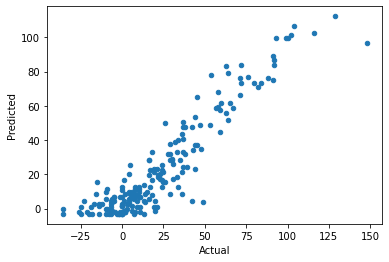

In [31]:
(results_df
 .sample(n=200, random_state = 123)
 .plot.scatter('Actual', 'Predicted')
)

**8. Model Evaluation**

9.111366197680459

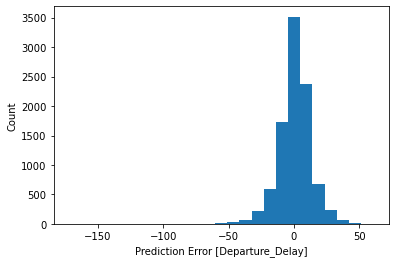

In [32]:
error = test_predictions - y_test
plt.hist(error, bins = 25)
plt.xlabel("Prediction Error [Departure_Delay]")
_ = plt.ylabel("Count")


test_mae = abs(error).mean()

test_mae